In [ ]:
#!pip install polaris-ml
#!pip install fets
#!pip install mlflow
#!pip install --upgrade pip
#!pip install causalnex
#!python -c "import causalnex"
#!pip install torch
#!pip install pygraphviz

# 1. PRINT POLARIS GRAPH WITH CAUSALNEX

In [265]:
import os
import json
import pandas as pd
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

def count_graph_nodes_and_links(file):
    with open(file + ".json") as f:
        graph_1 = json.loads(f.read())
    list_graph_nodes = [x["id"] for x in graph_1["graph"]["nodes"]]
    df_graph_links = pd.DataFrame([x for x in graph_1["graph"]["links"]])
    return df_graph_links, list_graph_nodes


def get_free_nodes(df_links, list_nodes):
    free_nodes = []
    for node in list_nodes:
        if(node not in list(df_links["target"]) and node not in list(df_links["source"]) ):
            free_nodes.append(node)
    return free_nodes

print("Ok")

Ok


In [266]:
df_XGB_links, list_XGB_nodes  = count_graph_nodes_and_links("polaris_marsexpress_graphs/polaris_graph_XGB")
df_randomforest_links, list_randomforest_nodes = count_graph_nodes_and_links("polaris_marsexpress_graphs/polaris_graph_randomforest")
df_adaboost_links, list_adaboost_nodes = count_graph_nodes_and_links("polaris_marsexpress_graphs/polaris_graph_adaboost")
df_extratrees_links, list_extratrees_nodes = count_graph_nodes_and_links("polaris_marsexpress_graphs/polaris_graph_extratrees")
df_gradientboosting_links, list_gradientboosting_nodes = count_graph_nodes_and_links("polaris_marsexpress_graphs/polaris_graph_GradientBoosting")

display(df_XGB_links)

,source,target,value
0,NPWD2372,NPWD2491,0.114444
1,NPWD2401,NPWD2471,0.257266
2,NPWD2401,NPWD2482,0.607478
3,NPWD2472,NPWD2792,0.327523
4,NPWD2472,NPWD2801,0.105567
...,...,...,...
127,SLEW,NADIR,0.292761
128,SLEW,RADIO_SCIENCE,0.181101
129,WARMUP,NPWD2722,0.169065
130,WARMUP,MAINTENANCE,0.226871


In [267]:

edges = []
for i, row in df_XGB_links.iterrows():
    edges.append((row["source"], row["target"], {"weight": row["value"]}))

g = StructureModel(edges)


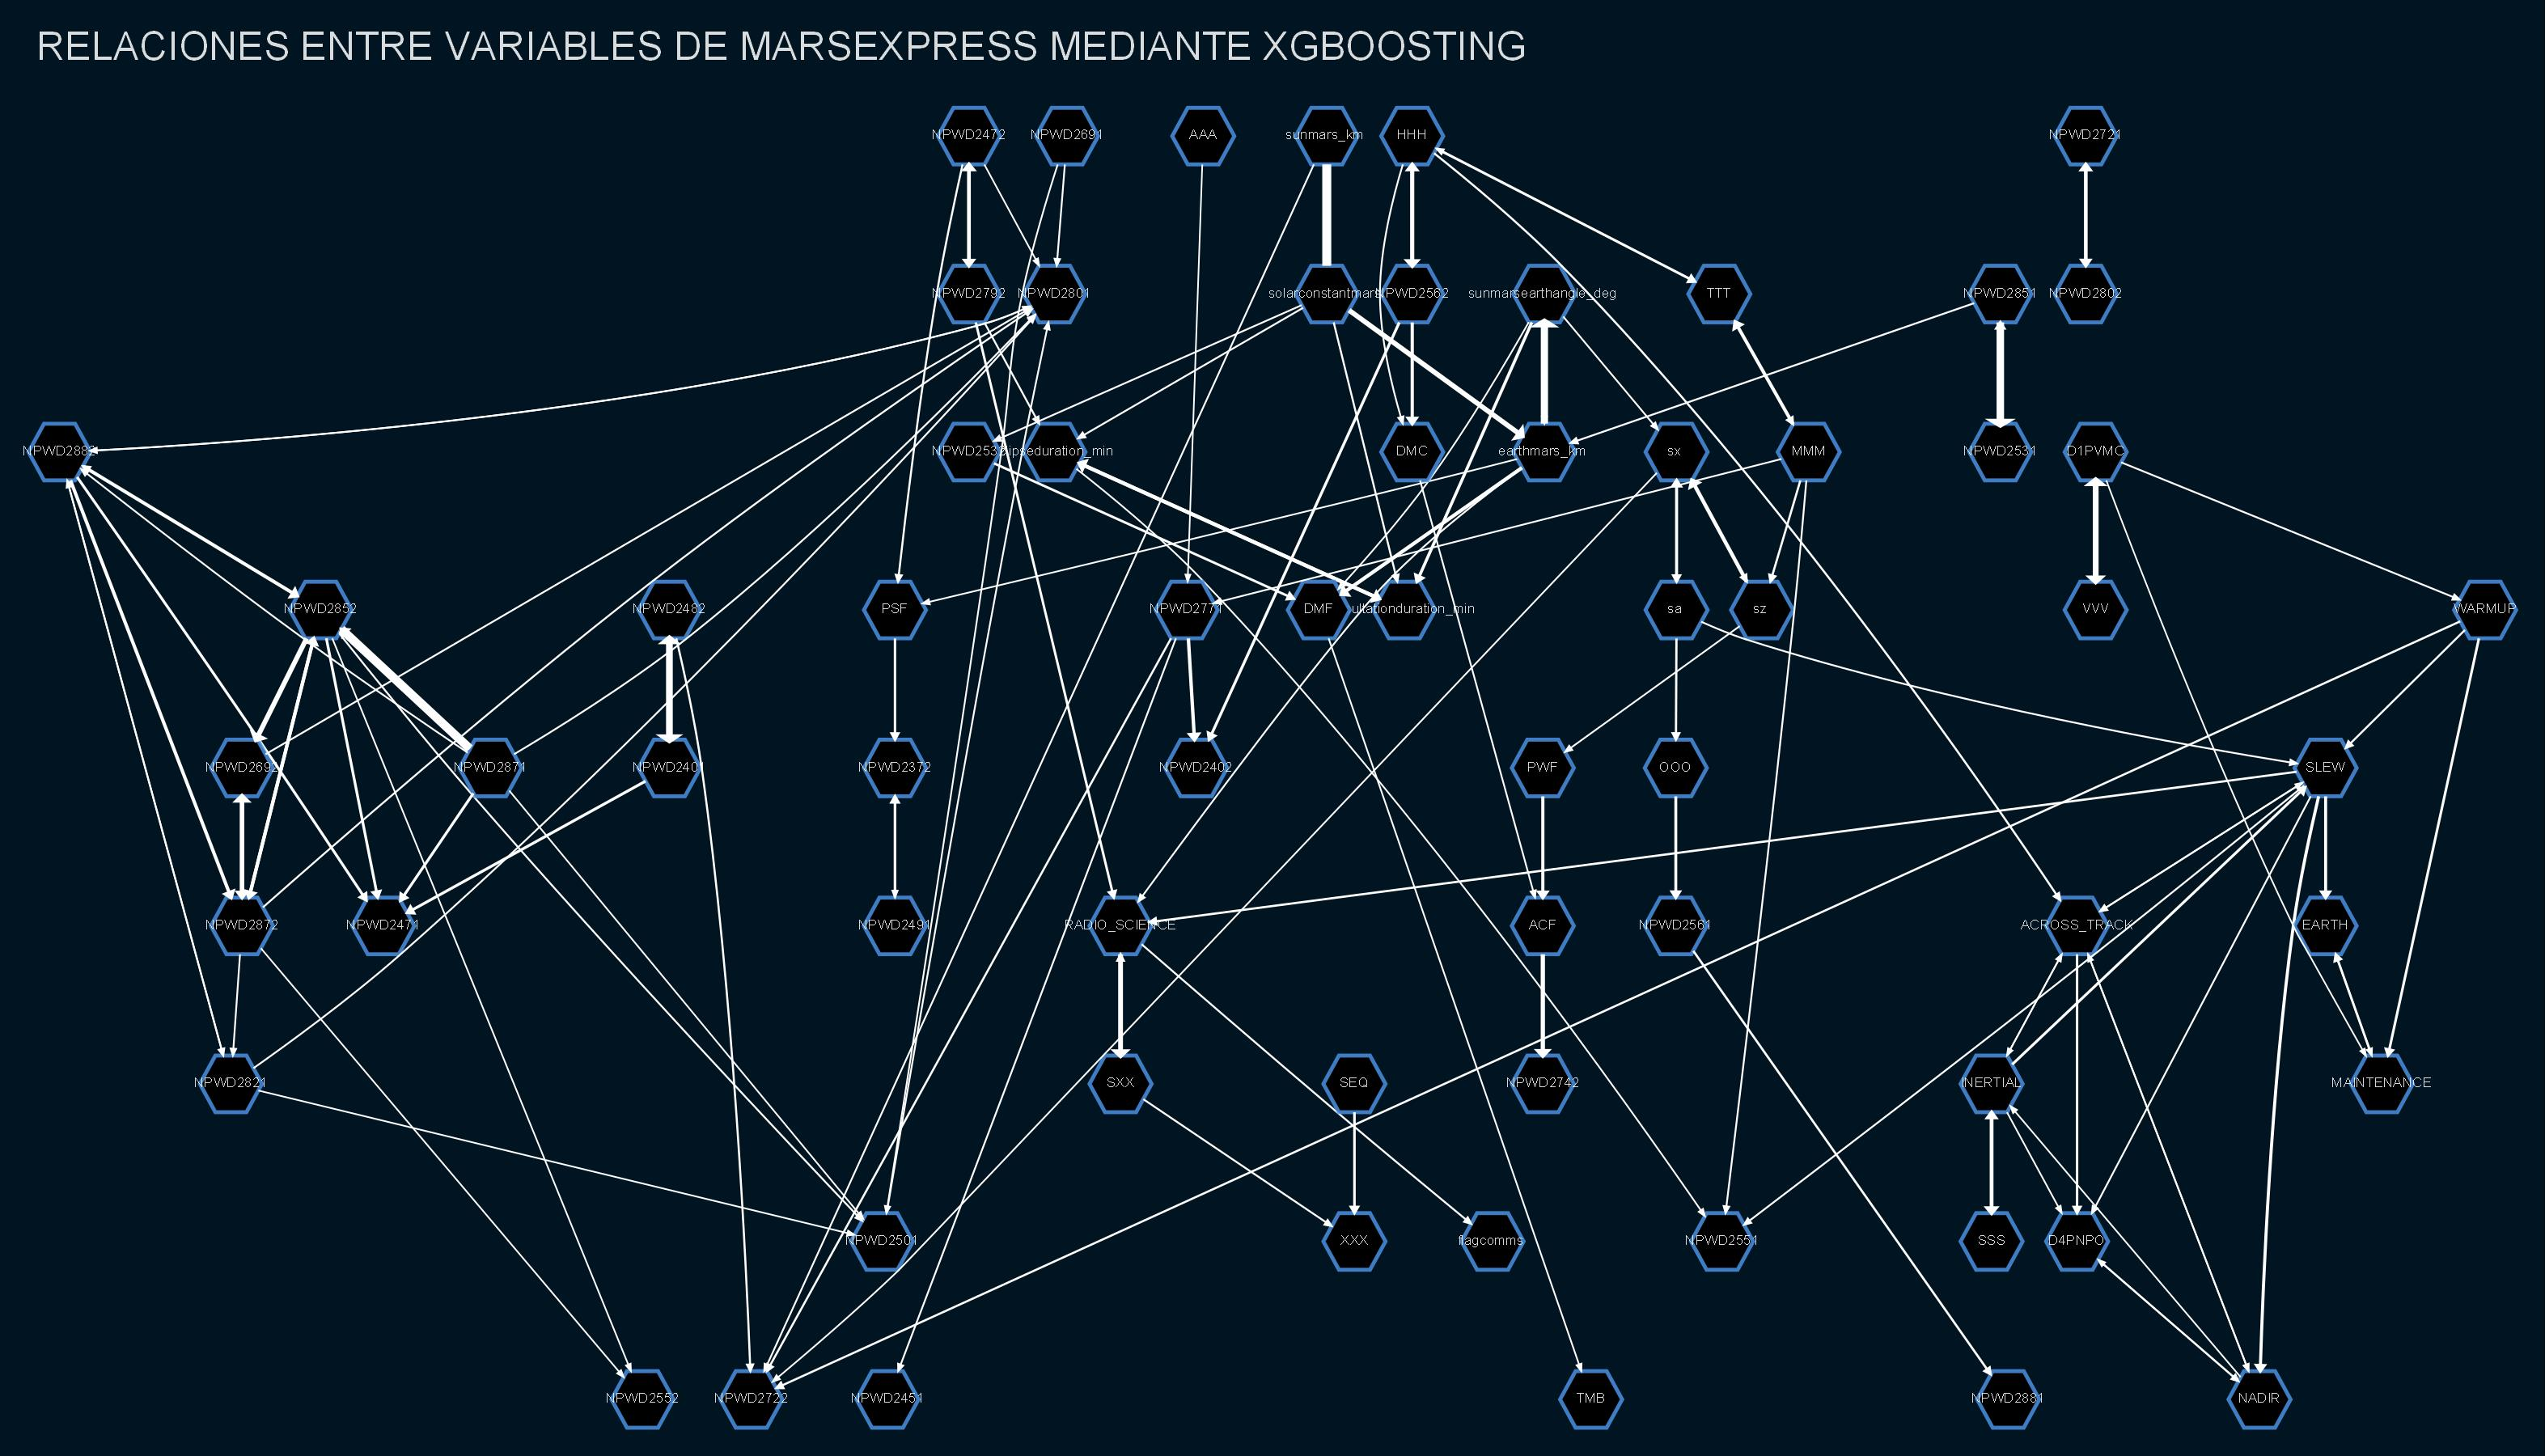

In [268]:
graph_attributes = {
    "splines": "spline",  # I use splies so that we have no overlap
    "ordering": "out",
    "ratio": "fill",  # This is necessary to control the size of the image
    "size": "16,9!",  # Set the size of the final image. (this is a typical presentation size)
    "label": "RELACIONES ENTRE VARIABLES DE MARSEXPRESS MEDIANTE XGBOOSTING",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "fontsize": 100,
    "labeljust": "l",
    "labelloc": "t",
    "pad": "1,1",
    "dpi": 200,
    "nodesep": 0.8,
    "ranksep": ".5 equally",
}

# Making all nodes hexagonal with black coloring
node_attributes = {
    node: {
        "shape": "hexagon",
        "width": 2.2,
        "height": 2,
        "fillcolor": "#000000",
        "penwidth": "10",
        "color": "#4a90e2d9",
        "fontsize": 35,
        "labelloc": "c",
    }
    for node in g.nodes
}

# Splitting two words with "\n"
for node in g.nodes:
    up_idx_array_origin = [i for i, c in enumerate(node) if c.isupper()]
    if len(up_idx_array_origin) > 0:
        up_idx = [up_idx_array_origin][-1][-1]
        node_attributes[node]["label"] = node[:up_idx] + "\n" + node[up_idx:]

# Target nodes (ones with "Cost" in the name) are colored differently
for node in g.nodes:
    if "Cost" in node:  # We color nodes with "cost" in the name with a orange colour.
        node_attributes[node]["fillcolor"] = "#DF5F00"

# Customising edges
edge_attributes = {
    (u, v): {
        "penwidth": w * 20 + 2,  # Setting edge thickness
        "weight": int(5 * w),  # Higher "weight"s mean shorter edges
        "arrowsize": 2 - 2.0 * w,  # Avoid too large arrows
        "arrowtail": "dot",
        "color": "white"
    }
    for u, v, w in g.edges(data="weight")
}


viz = plot_structure(
    g,
    prog="dot",
    graph_attributes=graph_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
f = "insurance_model.jpg"
viz.draw(f)
Image(f)

# CREAR GRAFO A PARTIR DE DATASET SKLEARN Y PYTORCH


In [136]:
import pandas as pd
data_df = pd.read_csv("preprocess_mars_express/MarsExpressPower/marsexpress_dataset.csv")
#data = data.drop("ut_ms", axis = 1)
#data = pd.read_csv("student-por.csv")

## Evaluación del sesgo del conjunto de datos

In [135]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

from IPython.display import display, Markdown
import pandas as pd

def variable_score_card(protected_variable: pd.Series, target: pd.Series, n_bins: int = 3):

    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_

    def pct_size():
        def pct_size_(x):
            return np.round(x.size / len(target) * 100, 1)
        pct_size_.__name__ = 'pct_size'
        return pct_size_

    display(Markdown("**Score card for ``%s``**" % protected_variable.name))

    agg_funcs = ["size", pct_size(), "mean", "std", "min", percentile(10), "median", percentile(90), "max"]
    if protected_variable.dtype != 'O' and protected_variable.nunique() < 10:
        return y.groupby(protected_variable).agg(agg_funcs).reset_index()
    else:
        bin_array = pd.cut(protected_variable, bins=n_bins)
        return y.groupby(bin_array).agg(agg_funcs).reset_index()

import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:

X = pd.read_pickle("preprocess_mars_express\\data\\mars-express-power-3years\\preprocessed\\train_x.pkl")
Y = pd.read_pickle("preprocess_mars_express\\data\\mars-express-power-3years\\preprocessed\\train_y.pkl")
data = {"data": X, "target": Y, "feature_names":list(X.columns)}



In [139]:
y = Y["NPWD2372"]


variable_score_card(protected_variable=X["occultationduration_min"], target=y)

**Score card for ``occultationduration_min``**

,occultationduration_min,size,pct_size,mean,std,min,percentile_10,median,percentile_90,max
0,"(-0.0877, 29.244]",32819,66.8,0.129043,0.040540,0.001457,0.080992,0.124711,0.187410,0.376517
1,"(29.244, 58.489]",14316,29.1,0.125371,0.037778,0.001821,0.081453,0.120225,0.180980,0.248477
2,"(58.489, 87.733]",1990,4.1,0.105497,0.035811,0.001902,0.067609,0.101259,0.156372,0.224127


In [140]:
#from sklearn.datasets import load_diabetes
#data = load_diabetes()
#X, y = data.data, data.target

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

MEAN R2: 0.389


## Regresor DAG lineal

In [150]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import torch
torch.manual_seed(42)
#data = load_diabetes()
X, y = data["data"], data["target"]
names = data["feature_names"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=None,
    dependent_target=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y["NPWD2372"])

reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)



MEAN R2: nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Regresor DAG no lineal

MEAN R2: nan


(<Figure size 957.6x573.12 with 1 Axes>, <AxesSubplot:>)

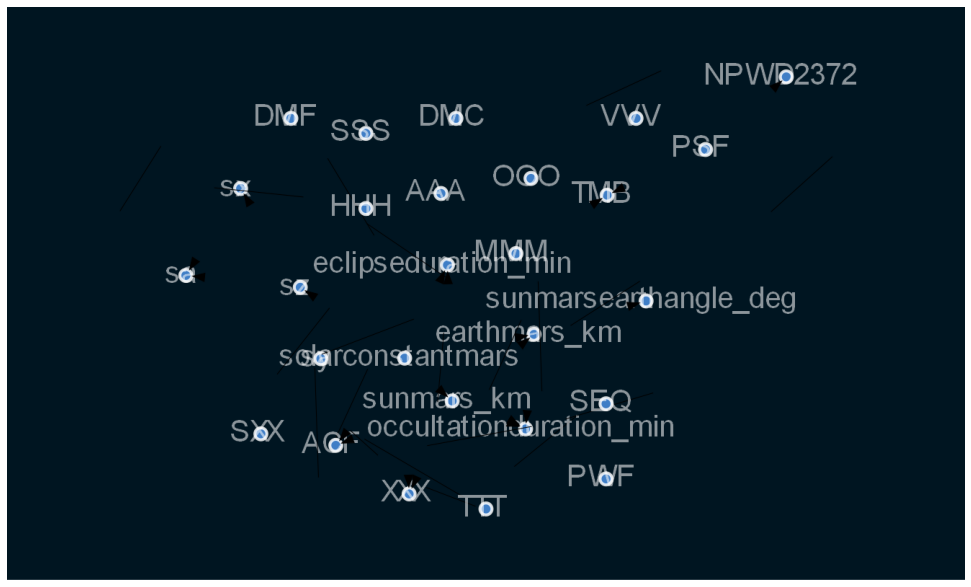

In [153]:
#from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(42)
#data = load_diabetes()
X, y = data["data"], data["target"]
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[2],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y["NPWD2372"])
reg.fit(X, y)
reg.plot_dag(enforce_dag=True)

In [154]:
#GET DATAFRAME FROM GRAPH

list_of_edges = []
for key in reg.graph_.adj:
    for i in reg.graph_.adj[key]:
        list_of_edges.append((key, i , {"weight" : reg.graph_.adj[key][i]["weight"]}))

display(pd.DataFrame(list_of_edges, columns=["source", "target", "weight"]))

,source,target,weight
0,sx,sa,{'weight': 1.3408271074295044}
1,sz,sa,{'weight': 1.2275664806365967}
2,sz,sx,{'weight': 0.6651266813278198}
3,sunmars_km,earthmars_km,{'weight': 0.44690343737602234}
4,sunmars_km,eclipseduration_min,{'weight': 3.8782739639282227}
5,sunmars_km,occultationduration_min,{'weight': 0.5110515356063843}
6,sunmars_km,XXX,{'weight': 0.9261749386787415}
7,sunmars_km,ACF,{'weight': 0.9752727150917053}
8,earthmars_km,sunmarsearthangle_deg,{'weight': 1.5362091064453125}
9,earthmars_km,occultationduration_min,{'weight': 0.7364456057548523}


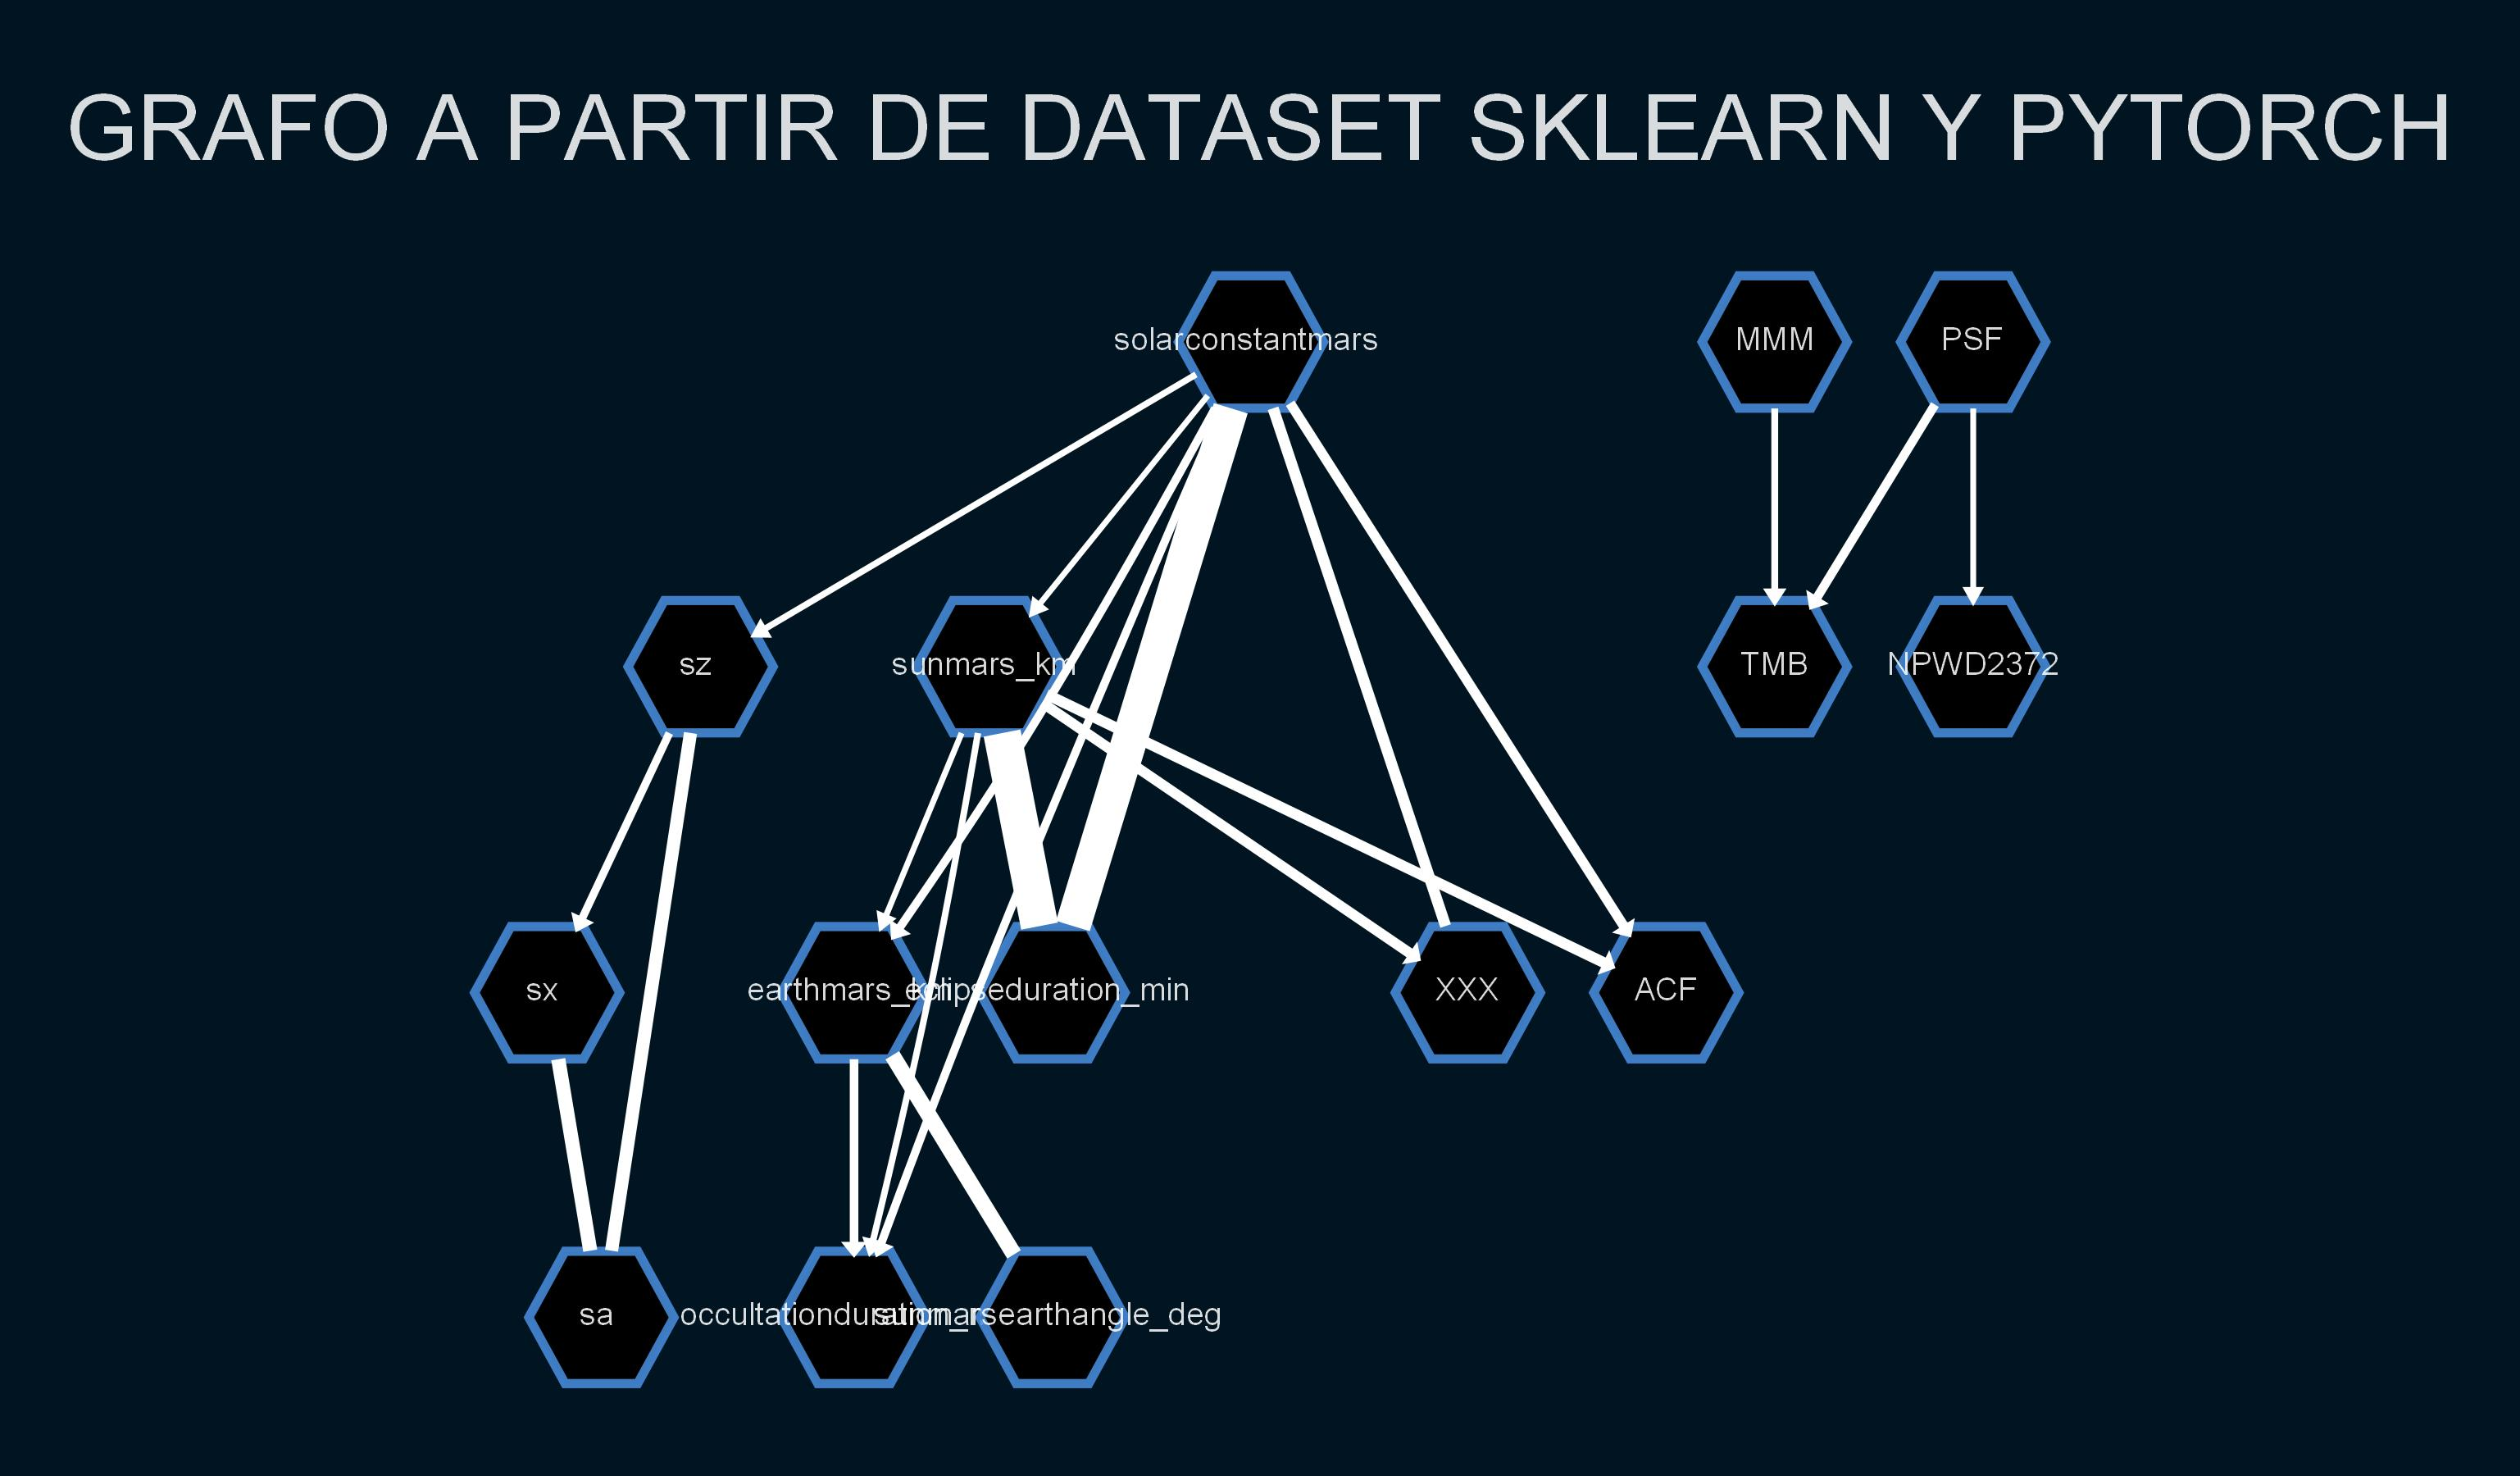

In [157]:
g = StructureModel(list_of_edges)

graph_attributes = {
    "splines": "spline",  # I use splies so that we have no overlap
    "ordering": "out",
    "ratio": "fill",  # This is necessary to control the size of the image
    "size": "16,9!",  # Set the size of the final image. (this is a typical presentation size)
    "label": "GRAFO A PARTIR DE DATASET SKLEARN Y PYTORCH",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "fontsize": 100,
    "labeljust": "l",
    "labelloc": "t",
    "pad": "1,1",
    "dpi": 200,
    "nodesep": 0.8,
    "ranksep": ".5 equally",
}

# Making all nodes hexagonal with black coloring
node_attributes = {
    node: {
        "shape": "hexagon",
        "width": 2.2,
        "height": 2,
        "fillcolor": "#000000",
        "penwidth": "10",
        "color": "#4a90e2d9",
        "fontsize": 35,
        "labelloc": "c",
    }
    for node in g.nodes
}

# Splitting two words with "\n"
for node in g.nodes:
    up_idx_array_origin = [i for i, c in enumerate(node) if c.isupper()]
    if len(up_idx_array_origin) > 0:
        up_idx = [up_idx_array_origin][-1][-1]
        node_attributes[node]["label"] = node[:up_idx] + "\n" + node[up_idx:]

# Target nodes (ones with "Cost" in the name) are colored differently
for node in g.nodes:
    if "Cost" in node:  # We color nodes with "cost" in the name with a orange colour.
        node_attributes[node]["fillcolor"] = "#DF5F00"


# Customising edges
edge_attributes = {
    (u, v): {
        "penwidth": w * 10 + 2,  # Setting edge thickness
        "weight": int(5 * w),  # Higher "weight"s mean shorter edges
        "arrowsize": 2 - 2.0 * w,  # Avoid too large arrows
        "arrowtail": "dot",
        "color": "white"
    }
    for u, v, w in g.edges(data="weight")
}


viz = plot_structure(
    g,
    prog="dot",
    graph_attributes=graph_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
f = "insurance_model.jpg"
viz.draw(f)
Image(f)


# CREAR GRAFO A PARTIR DE DATASET BAYESIAN NETWORK

## Definición del DAG con StructureModel

In [248]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("preprocess_mars_express/MarsExpressPower/marsexpress_dataset.csv").drop("ut_ms", axis=1)
train_data, test_data = train_test_split(data)

In [323]:
    from causalnex.structure.notears import from_pandas
    from causalnex.network import BayesianNetwork

    # Unconstrained learning of the structure from data
    # El algoritmo NOTEARS aprende la estructura del DAG directamente de los datos
    sm = from_pandas(data, max_iter=1800)
    # Imposing edges that are not allowed in the causal model
    #sm_with_tabu_edges = from_pandas(data, tabu_edges=[("e", "a")])
    # Imposing parent nodes that are not allowed in the causal model
    #sm_with_tabu_parents = from_pandas(data, tabu_parent_nodes=["NPWD2372", "NPWD2401", "NPWD2402"])
    #sm_with_tabu_parents = from_pandas(data, tabu_parent_nodes=["a", "c"])
    # Imposing child nodes that are not allowed in the causal model
    #sm_with_tabu_parents = from_pandas(data, tabu_child_nodes=["d", "e"])

In [ ]:
 # Se modifican las relaciones del DAG que se consideren espurias o que no se hayan incluido y sean relevantes
    #sm.remove_edge("a", "c")
    # Changing the direction of the learned edge
    # sm.remove_edge("c", "d")
    # sm.add_edge("d", "c", origin="learned")
    # Adding the edge that was not learned by the algorithm
    #sm.add_edge("a", "e", origin="expert")

In [328]:
#GET DATAFRAME FROM GRAPH

# La librería de causalnex no nos permite trabajar con grafos separados, tenemos dos, así que nos quedamos con el más grande.
sm = sm.get_target_subgraph("earthmars_km")

list_of_edges = []
for key in sm.adj:
    for i in sm.adj[key]:
        list_of_edges.append((key, i , {"weight" : sm.adj[key][i]["weight"]}))

display(pd.DataFrame(list_of_edges, columns=["source", "target", "weight"]))

,source,target,weight
0,NPWD2372,NPWD2401,{'weight': 2.812104956800684e-21}
1,NPWD2372,NPWD2402,{'weight': 2.7899044820070295e-19}
2,NPWD2372,NPWD2451,{'weight': 1.5042260557501122e-18}
3,NPWD2372,NPWD2471,{'weight': 1.1739583713812977e-21}
4,NPWD2372,NPWD2472,{'weight': 2.821976339118713e-21}
...,...,...,...
3301,DMC,TMB,{'weight': 5.143972888219007e-20}
3302,DMC,TTT,{'weight': 1.72456071923554e-18}
3303,DMC,VVV,{'weight': -1.2365259150071309e-18}
3304,DMC,XXX,{'weight': -3.5448274046256315e-19}


In [329]:
# Comprobamos si el grafo es cíclico

import networkx as nx
nx.is_directed_acyclic_graph(sm)
nx.find_cycle(sm)

[('NPWD2372', 'NPWD2401'), ('NPWD2401', 'NPWD2372')]

In [331]:

# Esta relación es cíclica e impide que podamos tratar el grafo como un DAG, así que eliminamos una de las dos aristas

sm.remove_edge('NPWD2372', 'NPWD2401')

nx.is_directed_acyclic_graph(sm)

False

In [ ]:
g = StructureModel(list_of_edges)

graph_attributes = {
    "splines": "spline",  # I use splies so that we have no overlap
    "ordering": "out",
    "ratio": "fill",  # This is necessary to control the size of the image
    "size": "16,9!",  # Set the size of the final image. (this is a typical presentation size)
    "label": "GRAFO A PARTIR DE DATASET SKLEARN Y PYTORCH",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "fontsize": 100,
    "labeljust": "l",
    "labelloc": "t",
    "pad": "1,1",
    "dpi": 200,
    "nodesep": 0.8,
    "ranksep": ".5 equally",
}

# Making all nodes hexagonal with black coloring
node_attributes = {
    node: {
        "shape": "hexagon",
        "width": 2.2,
        "height": 2,
        "fillcolor": "#000000",
        "penwidth": "10",
        "color": "#4a90e2d9",
        "fontsize": 12,
        "labelloc": "c",
    }
    for node in g.nodes
}

# Splitting two words with "\n"
for node in g.nodes:
    up_idx_array_origin = [i for i, c in enumerate(node) if c.isupper()]
    if len(up_idx_array_origin) > 0:
        up_idx = [up_idx_array_origin][-1][-1]
        node_attributes[node]["label"] = node[:up_idx] + "\n" + node[up_idx:]

# Target nodes (ones with "Cost" in the name) are colored differently
for node in g.nodes:
    if "Cost" in node:  # We color nodes with "cost" in the name with a orange colour.
        node_attributes[node]["fillcolor"] = "#DF5F00"


# Customising edges
edge_attributes = {
    (u, v): {
        "penwidth": w * 20 + 2,  # Setting edge thickness
        "weight": int(5 * w),  # Higher "weight"s mean shorter edges
        "arrowsize": 2 - 2.0 * w,  # Avoid too large arrows
        "arrowtail": "dot",
        "color": "white"
    }
    for u, v, w in g.edges(data="weight")
}


viz = plot_structure(
    g,
    prog="dot",
    graph_attributes=graph_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
f = "insurance_model.jpg"
viz.draw(f)
Image(f)


## Estimación de probabilidad y predicciones con BayesianNetwork

In [244]:
    from causalnex.network import BayesianNetwork
    from causalnex.discretiser import Discretiser

    # Inititalise BN with defined structure model
    bn = BayesianNetwork(sm)
    data_discrete = Discretiser(data)
    # First, learn all the possible states of the nodes using the whole dataset
    bn.fit_node_states(data_discrete)
    # Fit CPDs using the training dataset with the discretised continuous variable "c"
    train_data_discrete = train_data.copy()
    test_data_discrete = test_data.copy()
   # train_data_discrete["c"] = Discretiser(method="uniform").transform(discretised_data["c"].values)
    bn.fit_cpds(train_data_discrete, method="BayesianEstimator", bayes_prior="K2")

ValueError: The given structure is not acyclic. Please review the following cycle: [('NPWD2372', 'NPWD2402'), ('NPWD2402', 'NPWD2401'), ('NPWD2401', 'NPWD2372')]

In [238]:
predictions = bn.predict(test_data_discrete, "NPWD2372")
predicted_probabilities = bn.predict_probability(test_data_discrete, "NPWD2372")

NameError: name 'bn' is not defined

In [ ]:
    from causalnex.inference import InferenceEngine

    # Updating the model on the whole dataset
    bn.fit_cpds(data_discrete, method="BayesianEstimator", bayes_prior="K2")
    ie = InferenceEngine(bn)
    # Querying all the marginal probabilities of the model's distribution
    marginals = ie.query({})

In [ ]:
    # Querying the marginal probabilities of the model's distribution
    # after an observed state of the node "b"
    marginals_after_observations = ie.query({"b": True})


In [ ]:
    # Doing an intervention to the node "d"
    ie.do_intervention("d", True)
    # Querying all the updated marginal probabilities of the model's distribution
    marginals_after_interventions = ie.query({})
    # Re-introducing the original conditional dependencies
    ie.reset_do("d")